In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer, DPAdamGaussianOptimizer

In [3]:
train_path = "oct duke"

In [4]:
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

X_train = []
Y_train = []

for target in os.listdir(train_path):
    target_path = os.path.join(train_path, target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path, file)
        X_train.append(file_path)
        Y_train.append(target)

100%|██████████| 1407/1407 [00:00<00:00, 352784.90it/s]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [6]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

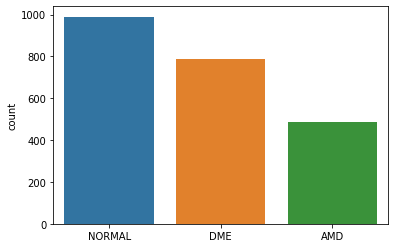

In [7]:
sns.countplot(x = Y_train)

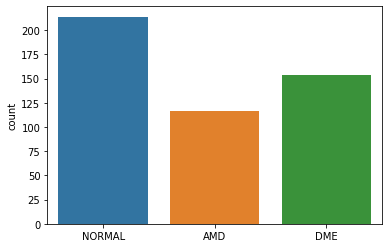

In [8]:
sns.countplot(x = Y_val)

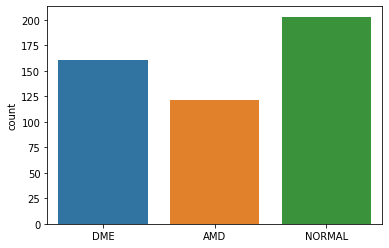

In [9]:
sns.countplot(x = Y_test)

In [10]:
df_train = pd.DataFrame(list(zip(X_train, Y_train)), columns =['image_path', 'label'])
df_val = pd.DataFrame(list(zip(X_val, Y_val)), columns =['image_path', 'label'])
df_test = pd.DataFrame(list(zip(X_test, Y_test)), columns =['image_path', 'label'])

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_aug = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator= train_aug.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

val_generator= test_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    color_mode="rgb",
    batch_size=16,
    shuffle = False, 
    target_size = (224, 224),
    class_mode="categorical")

Found 2261 validated image filenames belonging to 3 classes.
Found 485 validated image filenames belonging to 3 classes.
Found 485 validated image filenames belonging to 3 classes.


In [12]:
"""
This part is to modify the optimizer for the DP library of the tensorflow because it cannot run on the tensorflow 2.0+. 
This is the recognition credit for the notebook:
https://colab.research.google.com/github/ricardocarvalhods/dpcgan/blob/master/DP_CGAN_MNIST.ipynb#scrollTo=hOBQELw7mo9Z&line=21&uniqifier=1
"""
from absl import logging
import collections

from tensorflow_privacy.privacy.dp_query import gaussian_query

def make_optimizer_class(cls):
  """Constructs a DP optimizer class from an existing one."""
  parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
  child_code = cls.compute_gradients.__code__
  GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP  # pylint: disable=invalid-name
  if child_code is not parent_code:
    logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

  class DPOptimizerClass(cls):
    """Differentially private subclass of given class cls."""

    _GlobalState = collections.namedtuple(
      '_GlobalState', ['l2_norm_clip', 'stddev'])
    
    def __init__(
        self,
        dp_sum_query,
        num_microbatches=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg, g-doc-args
        **kwargs):
      """Initialize the DPOptimizerClass.

      Args:
        dp_sum_query: DPQuery object, specifying differential privacy
          mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
      """
      super(DPOptimizerClass, self).__init__(*args, **kwargs)
      self._dp_sum_query = dp_sum_query
      self._num_microbatches = num_microbatches
      self._global_state = self._dp_sum_query.initial_global_state()
      # TODO(b/122613513): Set unroll_microbatches=True to avoid this bug.
      # Beware: When num_microbatches is large (>100), enabling this parameter
      # may cause an OOM error.
      self._unroll_microbatches = unroll_microbatches

    def compute_gradients(self,
                          loss,
                          var_list,
                          gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False,
                          grad_loss=None,
                          gradient_tape=None,
                          curr_noise_mult=0,
                          curr_norm_clip=1):

      self._dp_sum_query = gaussian_query.GaussianSumQuery(curr_norm_clip, 
                                                           curr_norm_clip*curr_noise_mult)
      self._global_state = self._dp_sum_query.make_global_state(curr_norm_clip, 
                                                                curr_norm_clip*curr_noise_mult)
      

      # TF is running in Eager mode, check we received a vanilla tape.
      if not gradient_tape:
        raise ValueError('When in Eager mode, a tape needs to be passed.')

      vector_loss = loss()
      if self._num_microbatches is None:
        self._num_microbatches = tf.shape(input=vector_loss)[0]
      sample_state = self._dp_sum_query.initial_sample_state(var_list)
      microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
      sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

      def process_microbatch(i, sample_state):
        """Process one microbatch (record) with privacy helper."""
        microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
        grads = gradient_tape.gradient(microbatch_loss, var_list)
        sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
        return sample_state
    
      for idx in range(self._num_microbatches):
        sample_state = process_microbatch(idx, sample_state)

      if curr_noise_mult > 0:
        grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
      else:
        grad_sums = sample_state

      def normalize(v):
        return v / tf.cast(self._num_microbatches, tf.float32)

      final_grads = tf.nest.map_structure(normalize, grad_sums)
      grads_and_vars = final_grads#list(zip(final_grads, var_list))
    
      return grads_and_vars

  return DPOptimizerClass


def make_gaussian_optimizer_class(cls):
  """Constructs a DP optimizer with Gaussian averaging of updates."""

  class DPGaussianOptimizerClass(make_optimizer_class(cls)):
    """DP subclass of given class cls using Gaussian averaging."""

    def __init__(
        self,
        l2_norm_clip,
        noise_multiplier,
        num_microbatches=None,
        ledger=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
      dp_sum_query = gaussian_query.GaussianSumQuery(
          l2_norm_clip, l2_norm_clip * noise_multiplier)

      if ledger:
        dp_sum_query = privacy_ledger.QueryWithLedger(dp_sum_query,
                                                      ledger=ledger)

      super(DPGaussianOptimizerClass, self).__init__(
          dp_sum_query,
          num_microbatches,
          unroll_microbatches,
          *args,
          **kwargs)

    @property
    def ledger(self):
      return self._dp_sum_query.ledger

  return DPGaussianOptimizerClass

In [13]:
DPSGDGaussianOptimizer_new = make_gaussian_optimizer_class(tf.compat.v1.train.GradientDescentOptimizer)

In [14]:
l2_norm_clip = 1.5
noise_multiplier = 5
num_microbatches = 250
learning_rate = 0.0009

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications import ResNet50, InceptionResNetV2

def generate_model(pretrained_model = 'vgg16', num_classes=3):
    if pretrained_model == 'inceptionv3':
        base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    elif pretrained_model == 'inceptionresnet':
        base_model = InceptionResNetV2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3)) # Topless
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    #Freezing Convolutional Base
    for layer in base_model.layers[:-3]:
        layer.trainable = False  
    return model

In [16]:
def train_model(model, train_generator,val_generator, num_epochs, metrics):
    
    optimizer = DPSGDGaussianOptimizer_new(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
    
    loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
    
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=metrics)

    print(model.summary())
    
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=val_generator, verbose=1,
                        #callbacks = [early_stop, rlr]
                        )
    
    return model, history

In [17]:
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 3),
                tfa.metrics.F1Score(num_classes = 3),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot all ROC curves
#     for i in range(num_classes):
        #fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve of class {0}'.format(class_labels[i]))
        plt.legend(loc="lower right")
    plt.show()
    return roc_auc_score(y_test, y_pred)

In [18]:
def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot all ROC curves
#     for i in range(num_classes):
        #fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve of class {0}'.format(class_labels[i]))
        plt.legend(loc="lower right")
    plt.show()
    return roc_auc_score(y_test, y_pred)

In [19]:
def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROC AUC score:", plot_roc_curves(y_true, y_pred, 3, class_labels))

In [20]:
from keras.layers import Input, Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU, SeparableConv2D
from keras.models import Model, Sequential
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 64
second_filters = 128
third_filters = 256

dropout_conv = 0.3
dropout_dense = 0.3

# create a model with separable convolutional layers
def custom_model():
    inputs = Input((224, 224, 3))
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(inputs)
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(x)
    x = Conv2D(first_filters, kernel_size, activation = 'relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(second_filters, kernel_size, activation ='relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = Conv2D(third_filters, kernel_size, activation ='relu')(x)
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = Dropout(dropout_conv)(x)
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation = "softmax")(x)
    model = Model(inputs = inputs, outputs = x)
    model.summary
    return model

In [21]:
model = custom_model()

In [22]:
model, history = train_model(model, train_generator, val_generator, 100, metrics)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 218, 218, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 109, 109, 64)      0         
                                                             

c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


142/142 [==============================] - 44s 273ms/step - loss: 1.0308 - accuracy: 0.4662 - auc: 0.6549 - cohen_kappa: 0.0764 - f1_score: 0.3070 - precision: 0.5807 - recall: 0.1146 - val_loss: 1.0016 - val_accuracy: 0.5753 - val_auc: 0.7572 - val_cohen_kappa: 0.2936 - val_f1_score: 0.4649 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
142/142 [==============================] - 37s 261ms/step - loss: 0.9656 - accuracy: 0.5595 - auc: 0.7292 - cohen_kappa: 0.2724 - f1_score: 0.4943 - precision: 0.5961 - recall: 0.3114 - val_loss: 1.0108 - val_accuracy: 0.6330 - val_auc: 0.7892 - val_cohen_kappa: 0.3929 - val_f1_score: 0.5638 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
142/142 [==============================] - 37s 257ms/step - loss: 0.9319 - accuracy: 0.5838 - auc: 0.7498 - cohen_kappa: 0.3185 - f1_score: 0.5342 - precision: 0.6066 - recall: 0.3662 - val_loss: 0.9328 - val_accuracy: 0.5814 - val_auc: 0.7899 - val_cohen_kappa: 0.3182 - val_f1_score


Test set accuracy: 0.983505129814148 

31/31 [==============================] - 2s 72ms/step

              precision    recall  f1-score   support

         AMD       1.00      0.98      0.99       121
         DME       0.99      0.96      0.97       161
      NORMAL       0.97      1.00      0.99       203

    accuracy                           0.98       485
   macro avg       0.99      0.98      0.98       485
weighted avg       0.98      0.98      0.98       485



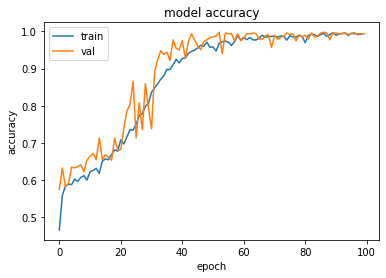

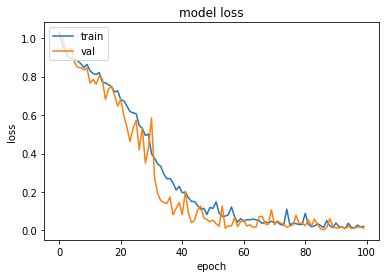

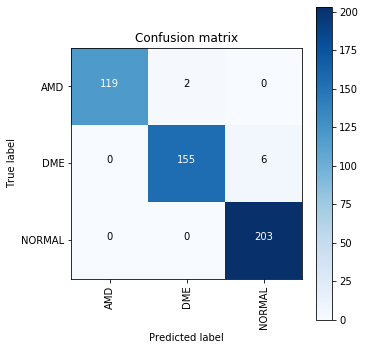

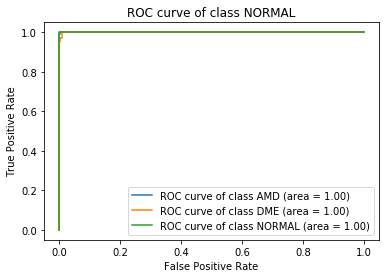

ROC AUC score: 0.9998774099564613


In [23]:
evaluate_model(model, history, test_generator)

In [24]:
import pandas as pd

In [25]:
from tensorflow.keras.utils import load_img, img_to_array
image_path= df_test['image_path'][105]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


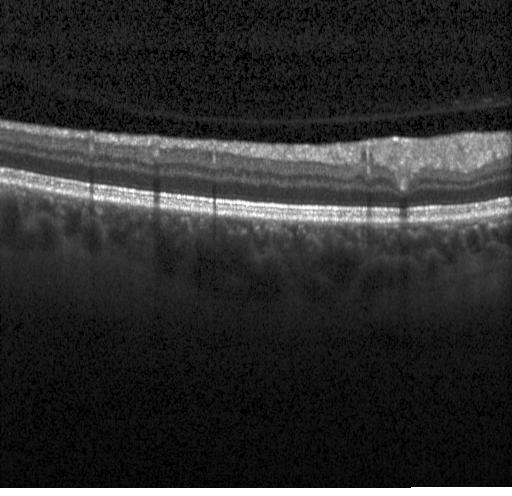

In [26]:
from PIL import Image
display(Image.open(image_path))

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.layers[-2].output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

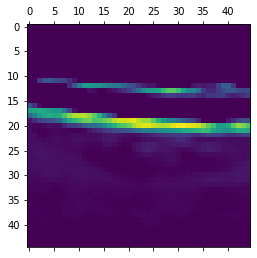

In [28]:
# Make model
model = model
last_conv_layer_name ="conv2d_8"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [29]:
import matplotlib.cm as cm
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))

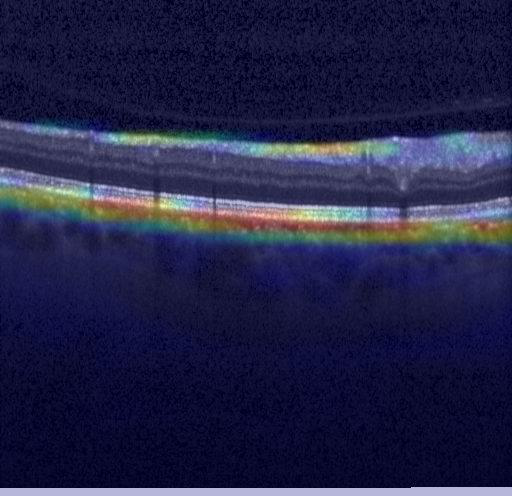

In [30]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest.jpg")

In [42]:
def train_model(model, train_generator,val_generator, num_epochs, optimizer, metrics):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=15, verbose=1)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    print(model.summary())
    
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=val_generator, verbose=1,
                        callbacks = [early_stop, rlr])
    
    return model, history

In [43]:
vgg_model = generate_model('vgg16', 3)

In [44]:
vgg_model, vgg_history = train_model(vgg_model, train_generator, val_generator, 20, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


None
Epoch 1/20
142/142 [==============================] - 29s 188ms/step - loss: 0.6276 - accuracy: 0.7373 - auc: 0.7104 - cohen_kappa: 0.3942 - f1_score: 0.5922 - precision: 0.5960 - recall: 0.5765 - val_loss: 0.3466 - val_accuracy: 0.8742 - val_auc: 0.9706 - val_cohen_kappa: 0.8008 - val_f1_score: 0.8729 - val_precision: 0.8861 - val_recall: 0.8660 - lr: 0.0010
Epoch 2/20
142/142 [==============================] - 25s 173ms/step - loss: 0.1253 - accuracy: 0.9593 - auc: 0.9956 - cohen_kappa: 0.9365 - f1_score: 0.9563 - precision: 0.9609 - recall: 0.9571 - val_loss: 0.0770 - val_accuracy: 0.9753 - val_auc: 0.9983 - val_cohen_kappa: 0.9616 - val_f1_score: 0.9726 - val_precision: 0.9753 - val_recall: 0.9753 - lr: 0.0010
Epoch 3/20
142/142 [==============================] - 25s 174ms/step - loss: 0.0917 - accuracy: 0.9651 - auc: 0.9969 - cohen_kappa: 0.9455 - f1_score: 0.9649 - precision: 0.9663 - recall: 0.9628 - val_loss: 0.0709 - val_accuracy: 0.9773 - val_auc: 0.9979 - val_cohen_kapp


Test set accuracy: 0.9958763122558594 

31/31 [==============================] - 2s 61ms/step

              precision    recall  f1-score   support

         AMD       1.00      0.99      1.00       121
         DME       1.00      0.99      1.00       161
      NORMAL       0.99      1.00      1.00       203

    accuracy                           1.00       485
   macro avg       1.00      1.00      1.00       485
weighted avg       1.00      1.00      1.00       485



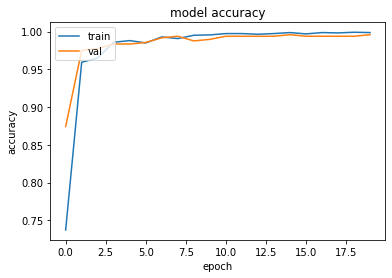

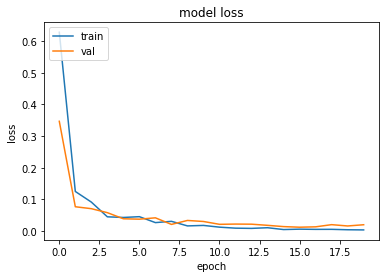

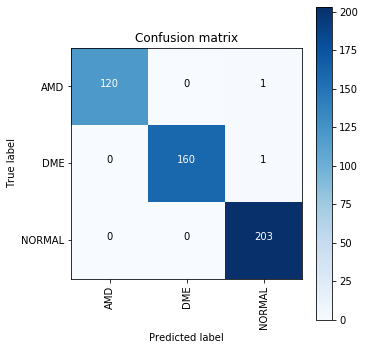

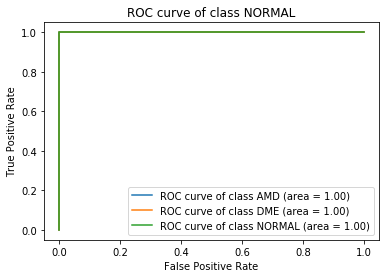

ROC AUC score: 1.0


In [45]:
evaluate_model(vgg_model, vgg_history, test_generator)

In [47]:
# vgg_model.save("/kaggle/working/vgg_model_weights.h5")

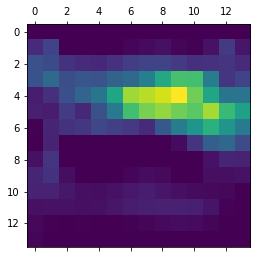

In [50]:
# Make model
model = vgg_model
last_conv_layer_name ="block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

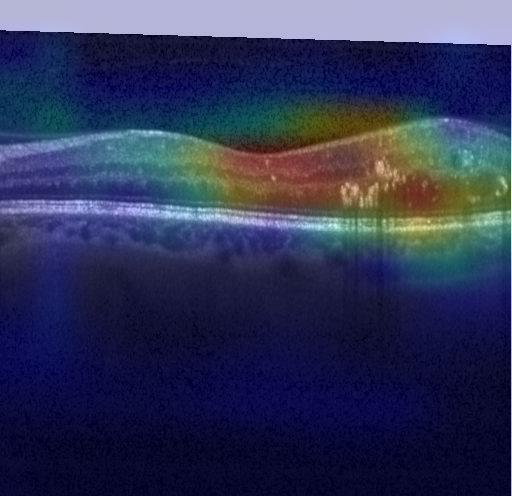

In [51]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest.jpg")

In [56]:
incres_model = generate_model('inceptionresnet', 3)

In [57]:
incres_model, incres_history = train_model(incres_model, train_generator, val_generator, 20, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_9[0][0]']               
 alization)                     )                                                           

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 activation_34 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_3_ac[0][0]']           
                                                                                                  
 conv2d_41 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_31[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_34[0][0]']          
                                                                                                  
 batch_normalization_30 (BatchN  (None, 25, 25, 32)  96          ['conv2d_39[0][0]']              
 ormalization)                                                                                    
          


Test set accuracy: 0.9958763122558594 

31/31 [==============================] - 5s 82ms/step

              precision    recall  f1-score   support

         AMD       0.99      1.00      1.00       121
         DME       0.99      0.99      0.99       161
      NORMAL       1.00      1.00      1.00       203

    accuracy                           1.00       485
   macro avg       1.00      1.00      1.00       485
weighted avg       1.00      1.00      1.00       485



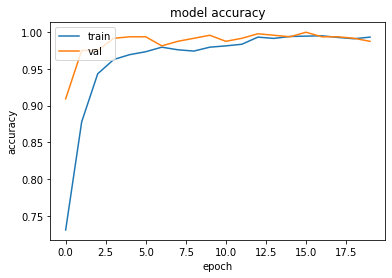

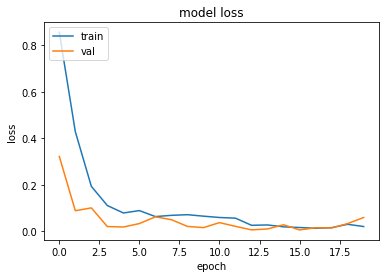

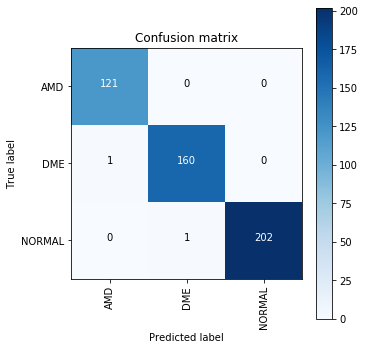

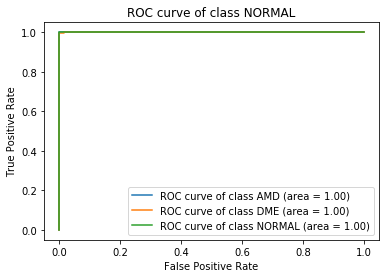

ROC AUC score: 0.9999680494849578


In [58]:
evaluate_model(incres_model, incres_history, test_generator)

In [60]:
from tensorflow.keras.utils import load_img, img_to_array
image_path= df_test['image_path'][80]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


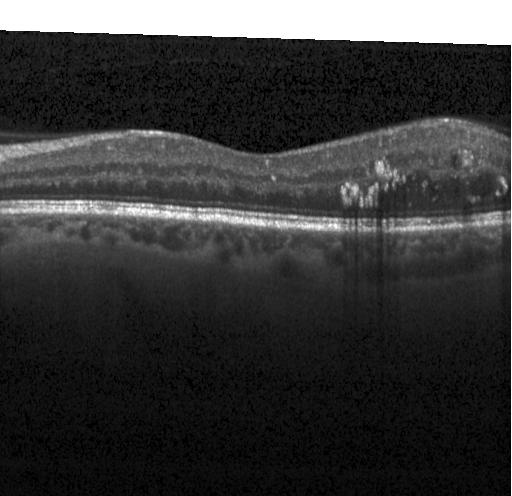

In [61]:
from PIL import Image
display(Image.open(image_path))

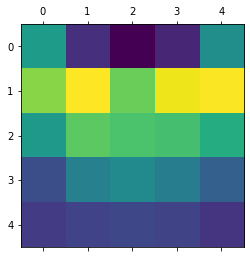

In [62]:
# Make model
model = incres_model
last_conv_layer_name ="conv_7b"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

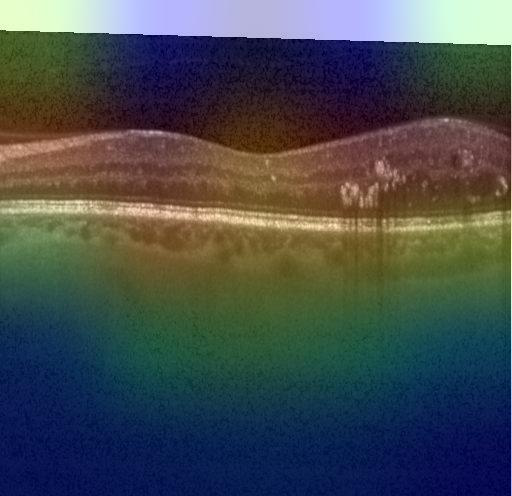

In [63]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest1.jpg")

In [64]:
from tensorflow.keras.utils import load_img, img_to_array
image_path= df_test2['image_path'][1000]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


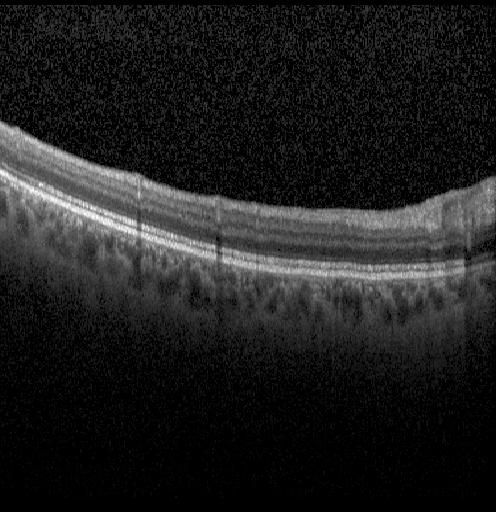

In [65]:
from PIL import Image
display(Image.open(image_path))

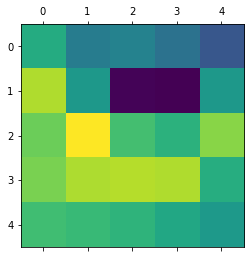

In [66]:
# Make model
model = incres_model
last_conv_layer_name ="conv_7b"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

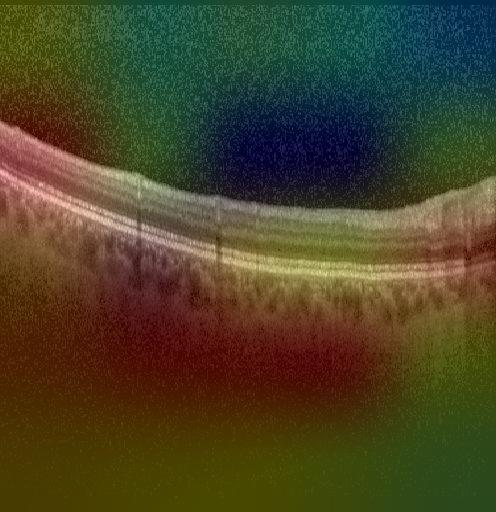

In [67]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest.jpg")

In [68]:
inception_model = generate_model('inceptionv3', 3)


ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
inception_model, inception_history = train_model(inception_model, train_generator, val_generator, 20, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_212[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________


Test set accuracy: 0.9896907210350037 

31/31 [==============================] - 3s 73ms/step

              precision    recall  f1-score   support

         AMD       1.00      0.97      0.98       121
         DME       0.98      1.00      0.99       155
      NORMAL       0.99      1.00      0.99       209

    accuracy                           0.99       485
   macro avg       0.99      0.99      0.99       485
weighted avg       0.99      0.99      0.99       485



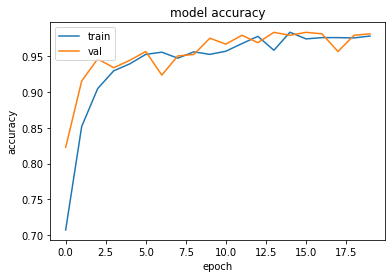

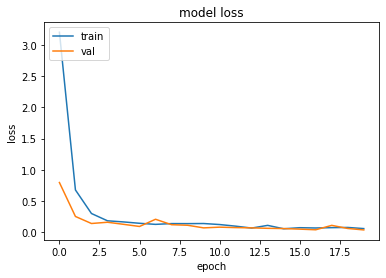

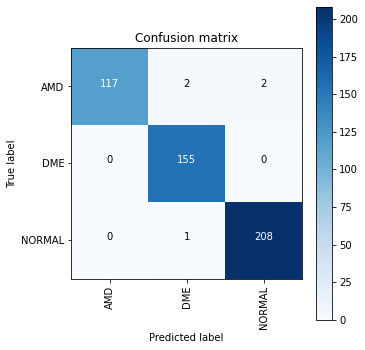

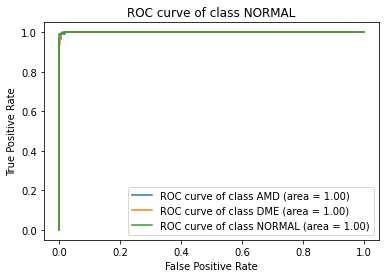

ROC AUC score: 0.9997887405100676


In [ ]:
evaluate_model(inception_model, inception_history, test_generator)


Test set accuracy: 0.625764012336731 

266/266 [==============================] - 19s 72ms/step

              precision    recall  f1-score   support

         AMD       0.90      0.57      0.70      1565
         DME       0.44      0.91      0.59      1104
      NORMAL       0.78      0.48      0.60      1585

    accuracy                           0.63      4254
   macro avg       0.71      0.65      0.63      4254
weighted avg       0.74      0.63      0.63      4254



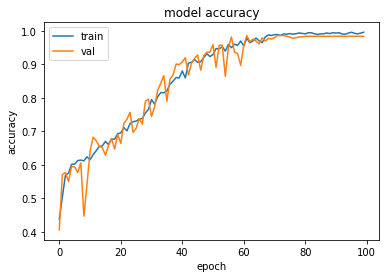

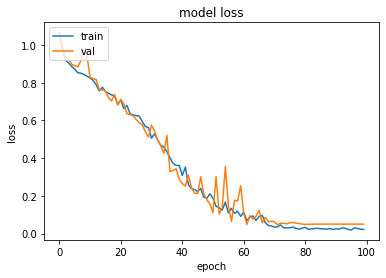

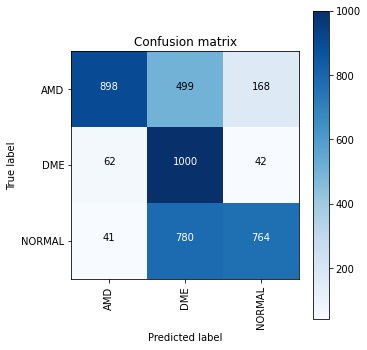

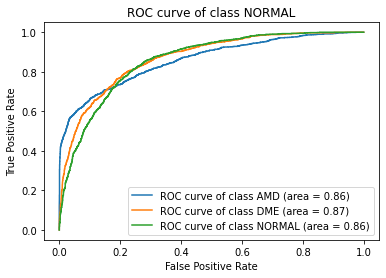

ROC AUC score: 0.8627509498450475


In [ ]:
evaluate_model(inception_model, history, test_generator2)

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
image_path= df_test['image_path'][80]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


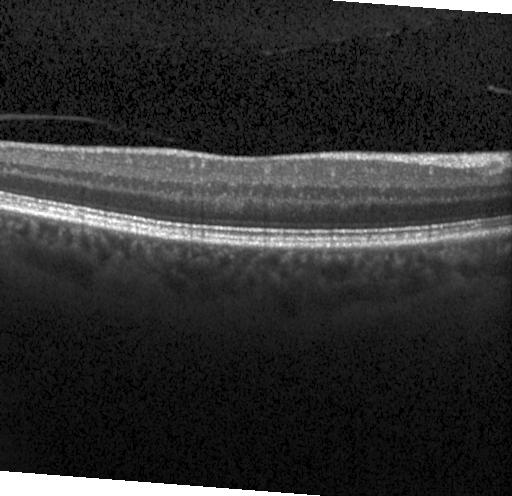

In [ ]:
from PIL import Image
display(Image.open(image_path))

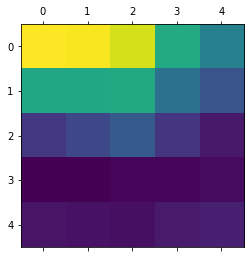

In [ ]:
# Make model
model = inception_model
last_conv_layer_name ="conv2d_305"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

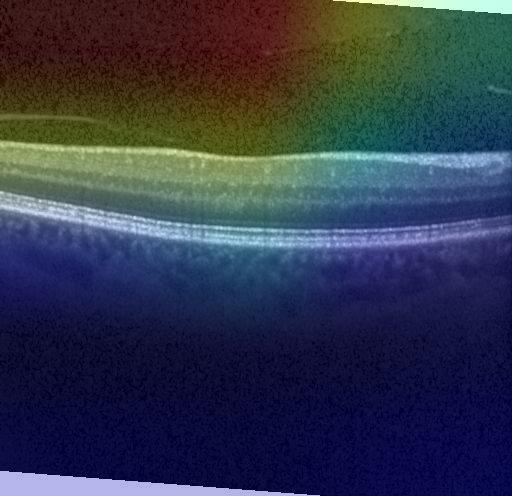

In [ ]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest3.jpg")

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
image_path= df_test2['image_path'][1000]
img = load_img(image_path, target_size=(224,224,3)) # stores image in PIL format
image_array=img_to_array(img)


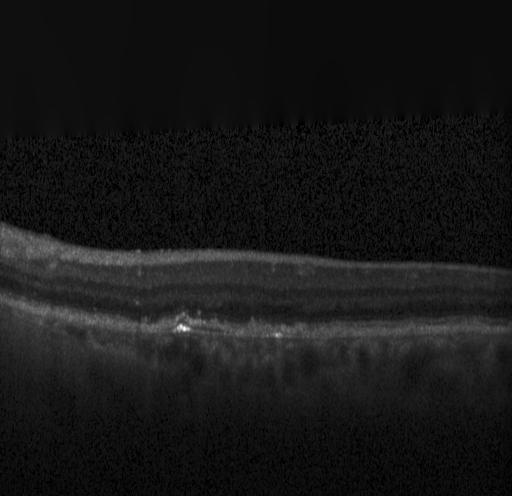

In [ ]:
from PIL import Image
display(Image.open(image_path))

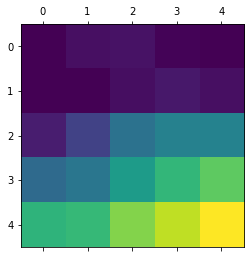

In [ ]:
# Make model
model = inception_model
last_conv_layer_name ="conv2d_305"
# Remove last layer's softmax
model.layers[-1].activation = None

img_array=np.expand_dims(image_array, axis=0)
# Prepare particular image 

# Generate class activation heatmap
heatmap= make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

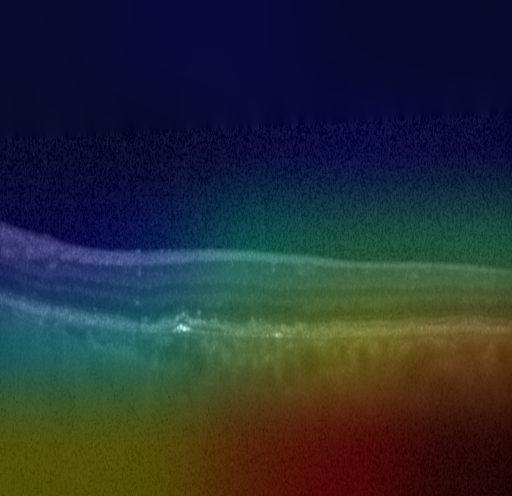

In [ ]:
save_and_display_gradcam(image_path, heatmap,cam_path="Gradcam/GradCamTest.jpg")